# Обучение и визуализация модели Mamba для генерации стихов

In [28]:
!python -V

import random
import math
import torch
import torch.nn as nn
from torch.autograd import Function
from torch import Tensor
from typing import Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import os
from collections import Counter
import re
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import warnings

random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings('ignore')

Python 3.12.3


In [2]:
dataset = load_dataset("abobster/pushkin_new")
os.makedirs("data", exist_ok=True)
with open("data/pushkin.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(dataset["train"]["text"]))

In [3]:
def tokenize_line(line):
    return re.findall(r"\w+|[^\w\s]", line.lower(), re.UNICODE)

all_tokens = [token for line in dataset["train"]["text"] for token in tokenize_line(line)]
vocab = {word: i + 2 for i, (word, _) in enumerate(Counter(all_tokens).most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    return [vocab.get(t, 1) for t in tokenize_line(text)]

vocab_size = len(vocab)

In [4]:
class PushkinDataset(Dataset):
    def __init__(self, texts, block_size=16):
        self.data = []
        for line in texts:
            tokens = encode(line)
            if len(tokens) >= 2:
                for i in range(0, len(tokens) - block_size):
                    x = tokens[i:i+block_size]
                    y = tokens[i+1:i+1+block_size]
                    self.data.append((x, y))
                    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

train_dataset = PushkinDataset(dataset["train"]["text"])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps - 1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8) -> None:
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: Tensor) -> Tensor:        
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.in_proj = nn.Linear(d_model, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.norm = RMSNorm(d_model)
        self.attention_weights = None

    def forward(self, x):
        x = self.norm(x)
        h = self.in_proj(x)
        B, C = self.s_B(h), self.s_C(h)
        self.attention_weights = torch.softmax((B @ C.transpose(-2, -1)), dim=-1)
        return h + B + C

class Mamba(nn.Module):
    def __init__(self, num_layers, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([MambaBlock(d_model) for _ in range(num_layers)])
        self.out_proj = nn.Linear(d_model, vocab_size)
        self.norm = RMSNorm(d_model)

    def forward(self, seq):
        x = self.embedding(seq)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return self.out_proj(x)
    
    def get_attention_maps(self):
        return [layer.attention_weights for layer in self.layers]

In [6]:
model = Mamba(num_layers=4, d_model=128)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Epoch 0: loss = 10.3436


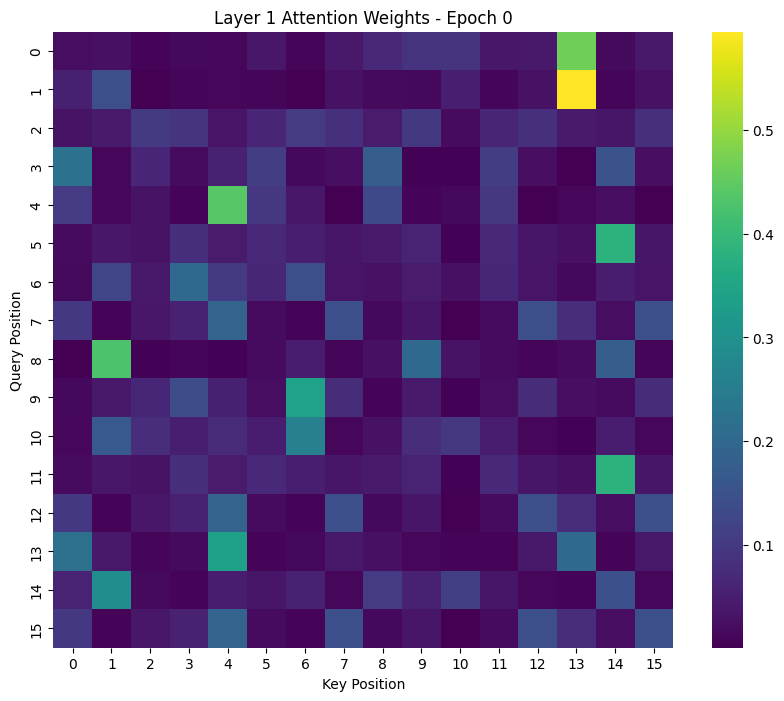

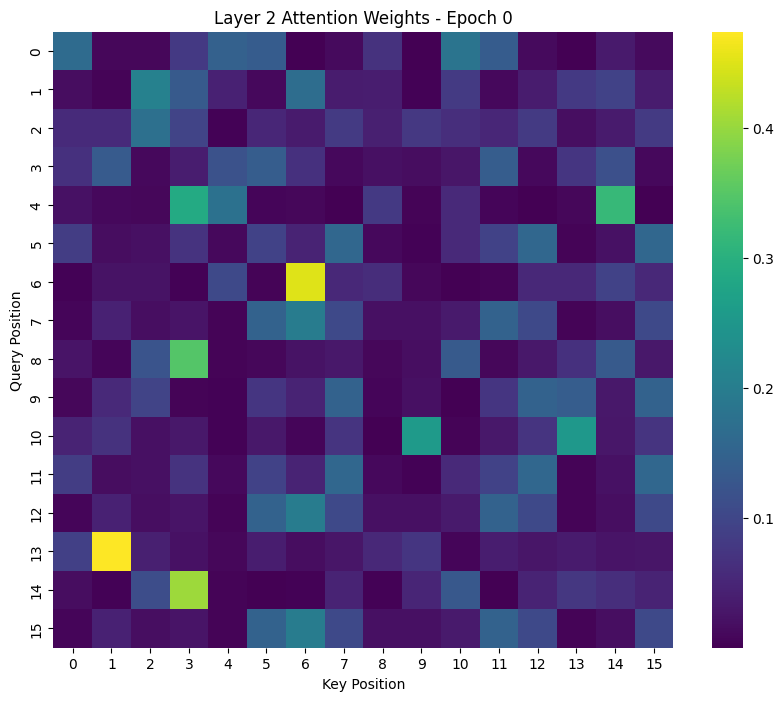

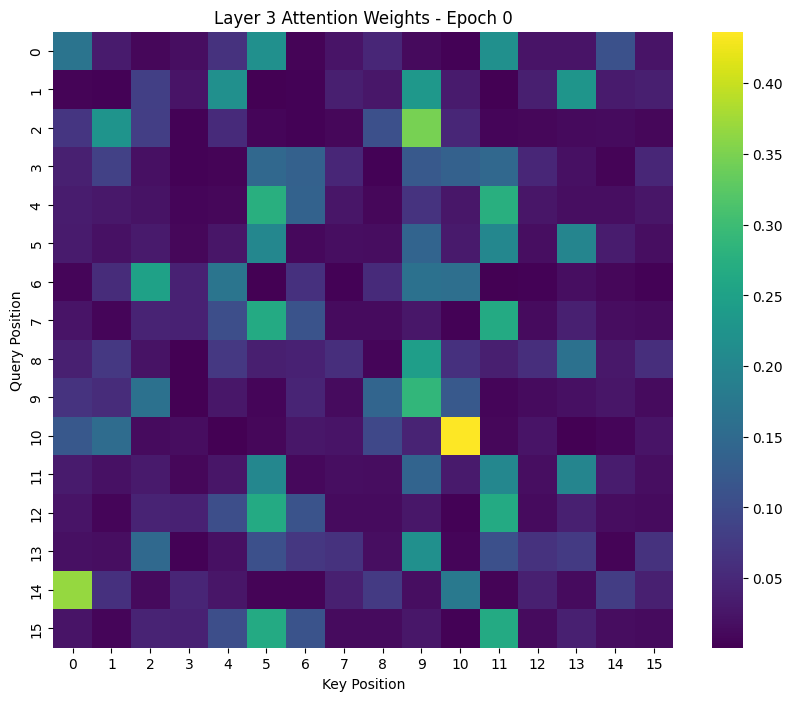

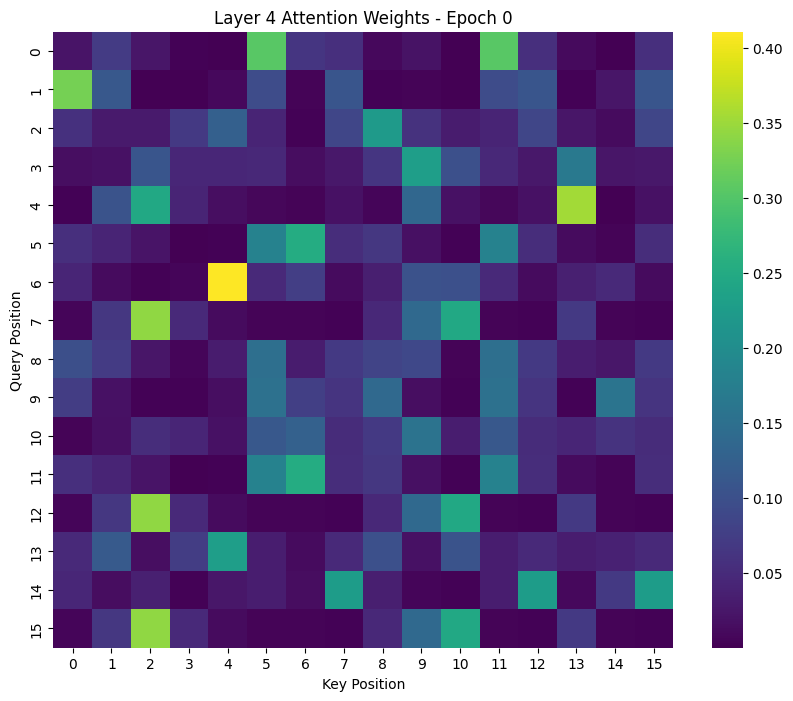

Epoch 50: loss = 0.6974
Epoch 100: loss = 0.6016
Epoch 150: loss = 0.5914
Epoch 200: loss = 0.5864
Epoch 250: loss = 0.5835
Epoch 300: loss = 0.5822
Epoch 350: loss = 0.5803
Epoch 400: loss = 0.5796
Epoch 450: loss = 0.5792
Epoch 500: loss = 0.5781


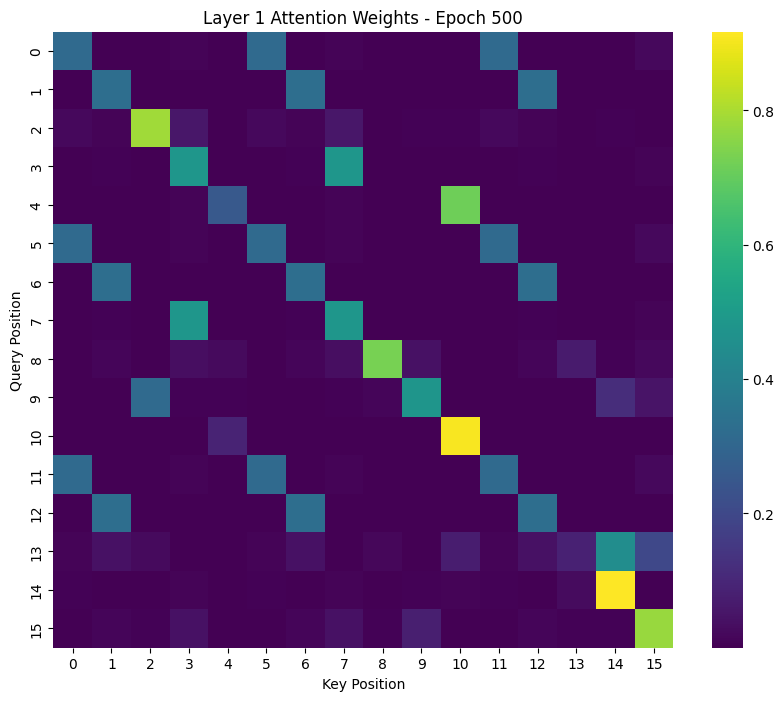

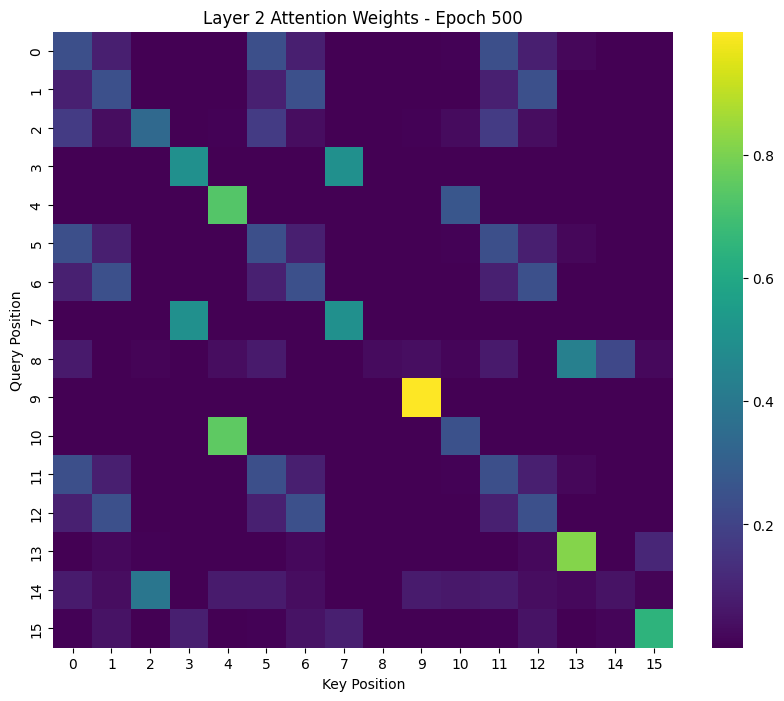

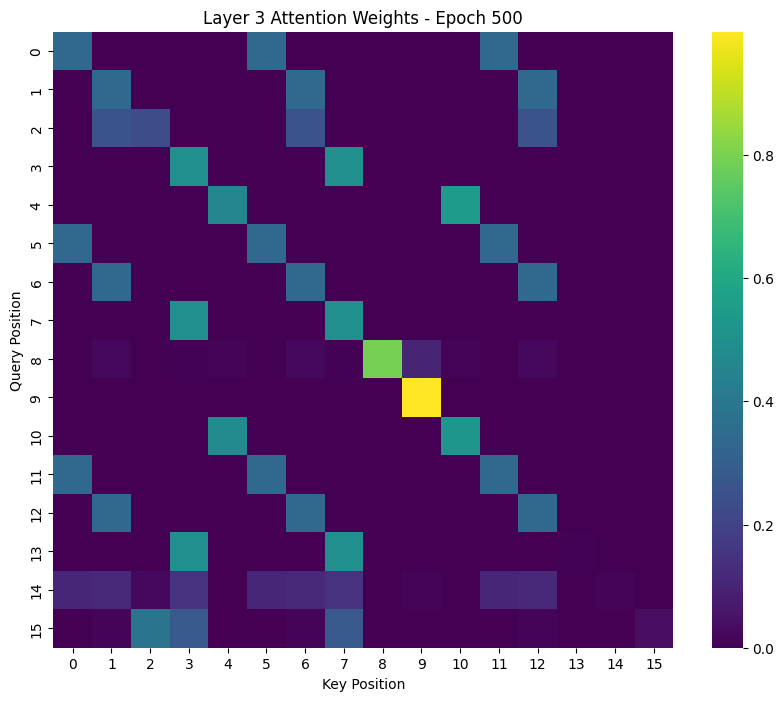

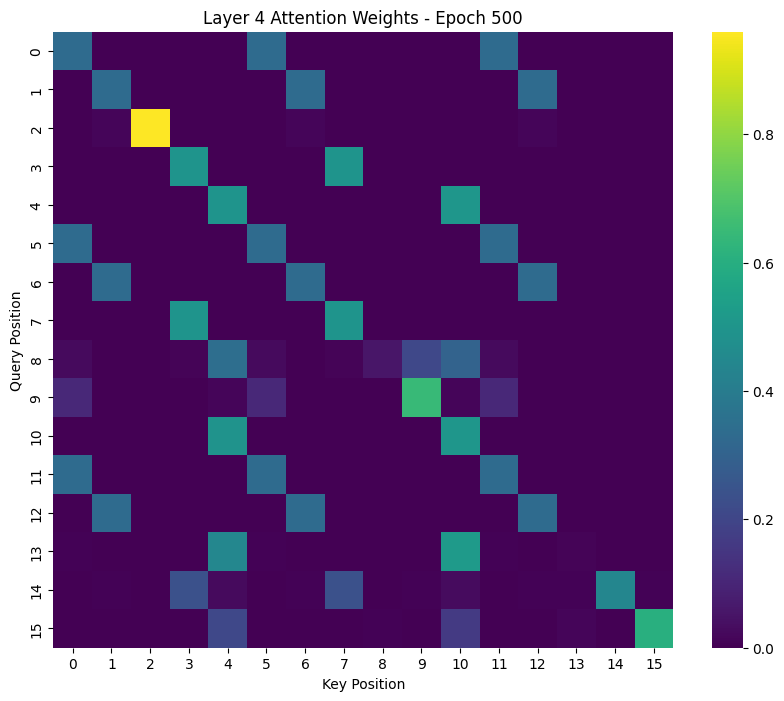

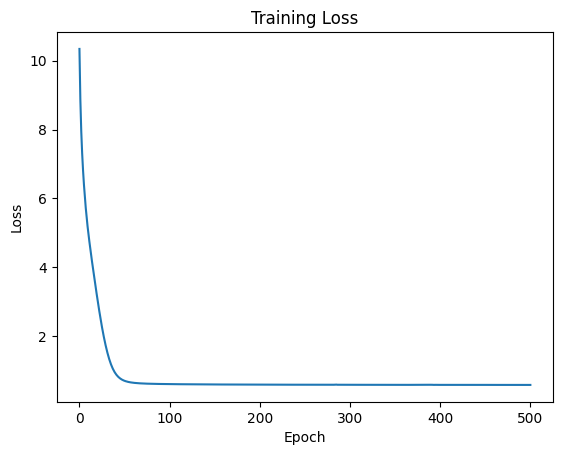

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

losses = []
for epoch in range(501):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.long().to(device), y.long().to(device)
        logits = model(x)
        loss = loss_fn(logits.view(-1, vocab_size), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    losses.append(total_loss)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: loss = {total_loss:.4f}")
        
        if epoch % 500 == 0:
            model.eval()
            with torch.no_grad():
                sample = next(iter(train_loader))[0][:1].to(device)
                _ = model(sample)
                attention_maps = model.get_attention_maps()
                
                for i, attn in enumerate(attention_maps):
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(attn[0].cpu().numpy(), cmap='viridis')
                    plt.title(f"Layer {i+1} Attention Weights - Epoch {epoch}")
                    plt.xlabel("Key Position")
                    plt.ylabel("Query Position")
                    plt.show()

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
def generate_text(model, starting_text, max_length=20, temperature=1.0):
    model.eval()
    tokens = encode(starting_text)
    generated = tokens.copy()
    
    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([generated[-16:]]).long().to(device)
            logits = model(x)
            logits = logits[0, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            
            next_token = torch.multinomial(probs, num_samples=1).item()
            generated.append(next_token)
            
            if next_token == 0:
                break
    
    idx_to_word = {idx: word for word, idx in vocab.items()}
    decoded = [idx_to_word.get(idx, "<UNK>") for idx in generated]
    return ' '.join(decoded)

starting_text = "Мой дядя самых честных правил, Когда не в шутку занемог, Он "

for i in range(3):
    continuation = generate_text(model, starting_text, max_length=20, temperature=(i + 1) * 0.8)
    print(f"{i+1}. {continuation}")

1. мой дядя самых честных правил , когда не в шутку занемог , он лезет « мой бог ! » , тире да точки . — « мой бог ! » , за что
2. мой дядя самых честных правил , когда не в шутку занемог , он трескучий » , за спадают ангелом смутное , за страшную веселий лихой то играло курганы радуясь девочкой ! » —
3. мой дядя самых честных правил , когда не в шутку занемог , он выше смутная благопристойно герою червонного приковали открывались ручьями вторую amour священный развелась ждет сладостью говорил побелевший детстве зловещей пигмей карающую


Анализ результатов:
1. Модель улавливает стихотворный ритм и пытается сохранить рифму ("занемог - мой бог - мой бог")
2. Модель не сохраняет смысловую связность с исходной фразой :c
3. Температура -- параметр, влияющий на креативность генерации, в нашем случае влияет на случайность слов.

Для улучшения результатов можно:
1. Добазить больше разнообразных текстов в обучающий набор
2. Настроить параметры модели
3. Реализовать дополнительные механизмы контроля за смысловой связностью